In [1]:
%matplotlib inline

import os
import tqdm
import json

import catboost
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from importlib import reload
import common
reload(common)
from common import (plot_features_target_correlation, plot_learning_curve, join_dataframes, 
                    get_sorted_factors, calculate_eval_metrics, plot_feature_importance, 
                    get_technical_indicators_df, plot_eval_metrics)

# SP 500 symbols

In [2]:
with open('../sp_500_symbols.txt', 'r') as f:
    sp_500_symbols = f.read().split('\n')[:-1]
    
len(sp_500_symbols)

505

# Data

In [3]:
tech_ind_dir = '/home/artem/Documents/ML-DS/AlgorithmicTrading/tech_ind_data_202012'

In [4]:
def read_df(tech_ind_dir_path, tech_ind_postfix, symbols):
    df = pd.DataFrame()
    for s in tqdm.tqdm(symbols):
        tech_ind_df_path = os.path.join(tech_ind_dir_path, s + tech_ind_postfix)
        if not os.path.exists(tech_ind_df_path):
            print('No tech indices for {}'.format(s))
            continue
        tech_ind_df = pd.read_csv(tech_ind_df_path)
        tech_ind_df.sort_values('date', inplace=True)
        
        columns = tech_ind_df.columns
        
        columns_to_prev = {c: 'prev_' + c for c in columns}
        columns_to_next = {'mom_1': 'next_mom_1'}
        
        prev_cur_tech_ind_df = tech_ind_df[:-2].copy()
        cur_cur_tech_ind_df = tech_ind_df[1:-1].copy()
        next_cur_tech_ind_df = tech_ind_df[2:].copy()
        
        prev_cur_tech_ind_df.rename(columns=columns_to_prev, inplace=True)
        next_cur_tech_ind_df.rename(columns=columns_to_next, inplace=True)
        
        prev_cur_tech_ind_df.reset_index(drop=True, inplace=True)
        cur_cur_tech_ind_df.reset_index(drop=True, inplace=True)
        next_cur_tech_ind_df.reset_index(drop=True, inplace=True)
        
        cur_cur_tech_ind_df = pd.concat(
            [cur_cur_tech_ind_df, prev_cur_tech_ind_df, next_cur_tech_ind_df['next_mom_1']], 
            axis=1)

        df = df.append(cur_cur_tech_ind_df, ignore_index=True, sort=False)
    
    return df

In [5]:
df = read_df(tech_ind_dir, '_tech_ind.csv', sp_500_symbols)
df

 16%|█▋        | 83/505 [00:12<01:42,  4.14it/s]

No tech indices for BF.B


 19%|█▉        | 96/505 [00:15<01:38,  4.14it/s]

No tech indices for CBS


100%|██████████| 505/505 [05:23<00:00,  1.25s/it]


,date,sma_9,sma_13,sma_26,mom_1,mom_8,mom_15,rsi_7,rsi_14,slowd,...,prev_mfi_14,prev_chaikin_a/d,prev_obv,prev_bbands_14_up,prev_bbands_14_mid,prev_bbands_14_low,prev_bbands_7_mid,prev_bbands_7_up,prev_bbands_7_low,next_mom_1
0,2000-01-13,29.0948,28.9555,28.2901,0.0000,1.8926,2.5028,60.6273,58.5058,80.6800,...,70.5607,-1.193372e+07,24565000.0,30.8074,28.6984,26.5893,29.1879,31.6104,26.7654,-0.4392
1,2000-01-14,29.2563,29.0106,28.3503,-0.4392,2.5588,1.8425,52.8857,54.7953,76.7232,...,65.0705,-1.298110e+07,24565000.0,30.9059,28.8613,26.8168,29.6162,30.9598,28.2726,-0.6426
2,2000-01-18,29.4692,29.0022,28.3893,-0.6426,0.5542,0.9964,43.4215,49.8172,71.3575,...,59.1981,-1.456324e+07,22023200.0,30.9139,28.9784,27.0429,29.7872,30.4231,29.1513,0.4953
3,2000-01-19,29.5858,29.0573,28.4445,0.4953,-0.5866,0.5690,51.2631,53.3356,65.5783,...,54.2432,-1.667804e+07,19908400.0,30.9150,28.9837,27.0524,29.6326,30.6654,28.5998,-1.0848
4,2000-01-20,29.4001,28.9950,28.4603,-1.0848,-2.2611,-0.6987,37.8551,45.7663,57.2766,...,55.0692,-1.676205e+07,22536600.0,30.9390,29.0113,27.0835,29.4646,30.3816,28.5477,-0.0560
5,2000-01-21,29.1426,29.0077,28.4688,-0.0560,-2.1697,-0.4245,37.2680,45.4079,50.2236,...,49.2133,-1.906505e+07,19432000.0,30.9543,28.9849,27.0155,29.1627,30.3269,27.9984,-0.6456
6,2000-01-24,28.8298,29.0558,28.4404,-0.6456,-2.2846,-1.5123,30.8363,41.3859,39.7368,...,43.2916,-2.184997e+07,14940200.0,30.9583,28.9230,26.8877,28.9285,30.2709,27.5861,-0.4039
7,2000-01-25,28.5311,28.9680,28.4142,-0.4039,-2.7770,-0.8844,27.3869,39.0554,29.9066,...,42.6053,-2.322885e+07,11969200.0,31.0114,28.8887,26.7660,28.5895,30.1473,27.0317,1.4533
8,2000-01-26,28.3840,28.8662,28.4276,1.4533,-1.3236,1.6744,50.5911,49.9728,23.2571,...,41.7627,-2.511830e+07,8278000.0,30.9647,28.9045,26.8443,28.1928,29.8149,26.5707,-0.0177
9,2000-01-27,28.2350,28.7176,28.4592,-0.0177,-0.9021,0.2948,50.3626,49.8557,24.8517,...,45.6723,-2.572741e+07,15298800.0,30.9573,28.9268,26.8963,28.0664,29.4519,26.6809,-1.1792


# Inspect data

In [6]:
df.shape

(2382797, 59)

In [7]:
df.columns

Index(['date', 'sma_9', 'sma_13', 'sma_26', 'mom_1', 'mom_8', 'mom_15',
       'rsi_7', 'rsi_14', 'slowd', 'slowk', 'dema_13', 'dema_26', 'adx_7',
       'adx_14', 'cci_7', 'cci_14', 'aroon_up', 'aroon_down', 'mfi_7',
       'mfi_14', 'chaikin_a/d', 'obv', 'bbands_14_up', 'bbands_14_mid',
       'bbands_14_low', 'bbands_7_mid', 'bbands_7_up', 'bbands_7_low',
       'prev_date', 'prev_sma_9', 'prev_sma_13', 'prev_sma_26', 'prev_mom_1',
       'prev_mom_8', 'prev_mom_15', 'prev_rsi_7', 'prev_rsi_14', 'prev_slowd',
       'prev_slowk', 'prev_dema_13', 'prev_dema_26', 'prev_adx_7',
       'prev_adx_14', 'prev_cci_7', 'prev_cci_14', 'prev_aroon_up',
       'prev_aroon_down', 'prev_mfi_7', 'prev_mfi_14', 'prev_chaikin_a/d',
       'prev_obv', 'prev_bbands_14_up', 'prev_bbands_14_mid',
       'prev_bbands_14_low', 'prev_bbands_7_mid', 'prev_bbands_7_up',
       'prev_bbands_7_low', 'next_mom_1'],
      dtype='object')

In [8]:
df.sort_values(by='date', inplace=True)

In [9]:
df[-10:]

,date,sma_9,sma_13,sma_26,mom_1,mom_8,mom_15,rsi_7,rsi_14,slowd,...,prev_mfi_14,prev_chaikin_a/d,prev_obv,prev_bbands_14_up,prev_bbands_14_mid,prev_bbands_14_low,prev_bbands_7_mid,prev_bbands_7_up,prev_bbands_7_low,next_mom_1
1382811,2020-12-23,41.0256,41.5662,41.0088,1.64,-1.60,0.7300,53.6007,55.5255,27.1381,...,45.9871,6.566340e+07,381792851.0,44.1357,41.6393,39.1428,40.7157,42.4735,38.9579,-0.10
1388082,2020-12-23,128.5811,129.6138,128.1577,2.35,0.10,-0.1100,50.3435,56.2605,29.9424,...,34.7506,3.099950e+08,298257975.0,135.3996,130.3071,125.2147,128.5871,132.0032,125.1711,0.14
376224,2020-12-23 00:00:00,38.2067,38.5054,38.6046,0.51,3.10,1.0100,63.0964,56.3198,66.6172,...,49.9316,3.575206e+08,47342359.0,40.6001,38.5364,36.4728,38.2457,40.0184,36.4730,-0.66
381495,2020-12-23 00:00:00,97.3611,98.6954,99.6427,-0.29,-7.38,-8.4500,25.7070,42.2216,11.1182,...,33.1743,2.960402e+08,110118543.0,106.6753,99.9350,93.1947,97.6671,103.8504,91.4839,1.33
334057,2020-12-23 00:00:00,245.6567,243.7113,238.8157,-1.65,1.56,3.2137,50.6732,54.3326,75.4580,...,67.7817,3.806138e+08,338108640.0,251.8779,243.1149,234.3518,246.2814,253.3442,239.2187,3.74
349869,2020-12-23 00:00:00,247.8722,246.8223,245.3181,3.33,9.77,4.2800,63.1006,51.8198,65.4767,...,70.1589,1.582999e+08,369074486.0,251.3935,246.2464,241.0994,248.3171,251.2632,245.3711,-2.31
360411,2020-12-23 00:00:00,15.6600,15.9446,17.0897,0.41,-0.34,-2.6299,36.7303,37.7222,8.1929,...,11.7556,3.510934e+08,352884985.0,18.1351,16.2703,14.4055,15.6371,16.3094,14.9649,-0.10
355140,2020-12-23 00:00:00,697.3856,699.9977,696.0312,10.12,8.44,-11.0935,56.2880,57.4498,40.6900,...,35.5299,1.051658e+08,169099983.0,717.0419,701.0871,685.1324,696.8043,709.3164,684.2922,3.54
312974,2020-12-23 00:00:00,91.8167,92.6431,94.2252,-0.88,-0.97,-2.3900,41.4344,44.8782,30.8507,...,48.0731,7.969943e+08,824610290.0,95.8895,92.8250,89.7605,91.7371,93.5391,89.9352,0.73
323516,2020-12-23 00:00:00,79.5722,79.2546,78.0810,0.09,-0.59,2.6443,45.9007,49.7579,68.1623,...,59.2272,8.456396e+08,652163915.0,81.3952,78.9914,76.5877,79.7229,81.4949,77.9509,0.84


In [10]:
df[10:][['rsi_7', 'prev_rsi_7']]

,rsi_7,prev_rsi_7
1641814,49.6927,50.2022
1636543,66.0708,57.7991
1631272,21.0718,18.5346
1626001,46.9612,35.5797
1620730,52.6964,39.6951
1609267,53.6405,53.6405
1603996,69.5042,51.5856
1598725,64.0808,55.9698
137964,64.3417,60.8875
1593454,23.1316,31.1730


In [11]:
# dates, symbols_cnt = df.date.unique(), df.groupby('date').date.count().values

In [12]:
# plt.plot(dates, symbols_cnt)

In [13]:
df.groupby('date').date.count()

date
2000-01-13             381
2000-01-14             381
2000-01-18             381
2000-01-19             381
2000-01-20             381
2000-01-21             381
2000-01-24             381
2000-01-25             382
2000-01-26             382
2000-01-27             382
2000-01-28             382
2000-01-31             382
2000-02-01             382
2000-02-02             383
2000-02-03             383
2000-02-04             383
2000-02-07             383
2000-02-08             383
2000-02-09             383
2000-02-10             383
2000-02-11             383
2000-02-14             383
2000-02-15             383
2000-02-16             383
2000-02-17             383
2000-02-18             383
2000-02-22             383
2000-02-23             383
2000-02-24             383
2000-02-25             383
                      ... 
2020-12-03             466
2020-12-03 00:00:00      8
2020-12-04             466
2020-12-04 00:00:00      8
2020-12-07             466
2020-12-07 00:00:00    

In [14]:
df[['mom_1', 'next_mom_1']].tail(10)

,mom_1,next_mom_1
1382811,1.64,-0.10
1388082,2.35,0.14
376224,0.51,-0.66
381495,-0.29,1.33
334057,-1.65,3.74
349869,3.33,-2.31
360411,0.41,-0.10
355140,10.12,3.54
312974,-0.88,0.73
323516,0.09,0.84


In [15]:
df.isnull().any().any()

False

# Prepare training data

In [16]:
min_date = '2010-01-01'

In [17]:
df_filtered = df[df.date > min_date]

In [18]:
df_filtered.shape

(1321605, 59)

In [19]:
test_samples = 50000

min_test_date = df_filtered.iloc[-test_samples].date
min_test_date

'2020-07-27'

In [20]:
df_test = df_filtered[df_filtered.date >= min_test_date].copy()
df_train = df_filtered[df_filtered.date < min_test_date].copy()

In [21]:
df_test.date.min(), df_train.date.max()

('2020-07-27', '2020-07-24 00:00:00')

In [22]:
df_test['target'] = df_test['next_mom_1'] / df_test['sma_9']
df_test.drop(['date', 'prev_date', 'next_mom_1'], axis=1, inplace=True)
# df_test.drop(['next_mom_1'], axis=1, inplace=True)

df_train['target'] = df_train['next_mom_1'] / df_train['sma_9']
df_train.drop(['date', 'prev_date', 'next_mom_1'], axis=1, inplace=True)

In [23]:
df_test.shape, df_train.shape

((50359, 57), (1271246, 57))

In [24]:
df_train.drop(df_train[abs(df_train['target']) > 0.1].index, inplace=True)
# df_test.drop(df_test[abs(df_test['target']) > 0.1].index, inplace=True)

In [25]:
df_test.shape, df_train.shape

((50359, 57), (1266941, 57))

# Analyze trainig data

In [26]:
df_test['target'].mean(), df_train['target'].mean()

(0.0018978103136360405, 0.0005884692874422792)

In [27]:
df_train.columns

Index(['sma_9', 'sma_13', 'sma_26', 'mom_1', 'mom_8', 'mom_15', 'rsi_7',
       'rsi_14', 'slowd', 'slowk', 'dema_13', 'dema_26', 'adx_7', 'adx_14',
       'cci_7', 'cci_14', 'aroon_up', 'aroon_down', 'mfi_7', 'mfi_14',
       'chaikin_a/d', 'obv', 'bbands_14_up', 'bbands_14_mid', 'bbands_14_low',
       'bbands_7_mid', 'bbands_7_up', 'bbands_7_low', 'prev_sma_9',
       'prev_sma_13', 'prev_sma_26', 'prev_mom_1', 'prev_mom_8', 'prev_mom_15',
       'prev_rsi_7', 'prev_rsi_14', 'prev_slowd', 'prev_slowk', 'prev_dema_13',
       'prev_dema_26', 'prev_adx_7', 'prev_adx_14', 'prev_cci_7',
       'prev_cci_14', 'prev_aroon_up', 'prev_aroon_down', 'prev_mfi_7',
       'prev_mfi_14', 'prev_chaikin_a/d', 'prev_obv', 'prev_bbands_14_up',
       'prev_bbands_14_mid', 'prev_bbands_14_low', 'prev_bbands_7_mid',
       'prev_bbands_7_up', 'prev_bbands_7_low', 'target'],
      dtype='object')

In [28]:
# plot_features_target_correlation(df_train, 'train', 'target')

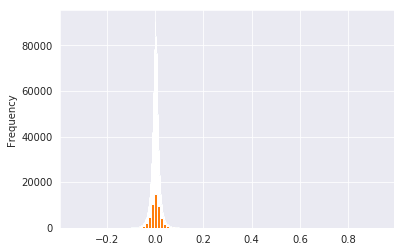

In [29]:
sns.set_style('darkgrid')
df_train['target'].plot(kind='hist', bins=100)
df_test['target'].plot(kind='hist', bins=100)

# Train model

In [30]:
def prepare_train_val(df, train_fr=0.9, should_print=True):
    train_data_size = int(len(df) * train_fr)
    if should_print:
        print('Train size: {} | Val size: {}'.format(train_data_size, len(df) - train_data_size))
#     df_shuffled = df.sample(frac=1)
    
    train = df[:train_data_size]
    val = df[train_data_size:].copy()
    
    return train, val

In [31]:
train, val = prepare_train_val(df_train)
train.head()

Train size: 1140246 | Val size: 126695


,sma_9,sma_13,sma_26,mom_1,mom_8,mom_15,rsi_7,rsi_14,slowd,slowk,...,prev_mfi_14,prev_chaikin_a/d,prev_obv,prev_bbands_14_up,prev_bbands_14_mid,prev_bbands_14_low,prev_bbands_7_mid,prev_bbands_7_up,prev_bbands_7_low,target
2325160,11.5862,11.5436,11.2075,0.3019,0.3099,0.7760,63.6791,62.9413,44.9114,43.1071,...,61.3877,9.448741e+07,46613500.0,11.8034,11.4809,11.1584,11.5901,11.7495,11.4306,0.021491
2237395,22.7527,22.6520,22.4920,-0.2031,0.1563,0.0468,46.0827,53.4012,67.7778,62.5926,...,47.5375,2.053586e+08,70987100.0,23.1238,22.6519,22.1801,22.8246,23.2107,22.4385,0.004808
39879,39.7548,39.6440,39.2635,-0.0968,-1.1035,0.5978,37.5927,48.8786,54.4589,39.1403,...,59.6020,5.966347e+07,-37896548.0,40.3771,39.6420,38.9069,39.7868,40.4457,39.1279,-0.005843
482968,16.5311,16.2195,16.0183,0.8339,1.0597,1.2161,73.5433,65.0289,82.5998,86.0127,...,50.1570,7.309097e+08,-101500133.0,17.0464,16.0785,15.1105,16.4967,16.6660,16.3274,-0.003152
859730,8.1717,8.1259,7.9337,0.2356,0.2148,0.5197,58.7136,58.3542,60.9474,57.2007,...,64.6574,5.668260e+07,4133400.0,8.3528,8.1029,7.8529,8.1831,8.4287,7.9374,-0.006779


In [32]:
threshold = 0
extract_target = lambda df: df.target.apply(lambda x: 1 if x > threshold else 0)
extract_weight = lambda df: df.target.apply(lambda x: 1 + abs(x - threshold) * 10)

train_x = train.drop(['target'], axis=1)
train_y = extract_target(train)
train_w = extract_weight(train)

val_x = val.drop(['target'], axis=1)
val_y = extract_target(val)
val_w = extract_weight(val)

test_x = df_test.drop(['target'], axis=1)
test_y = extract_target(val)
test_w = extract_weight(val)

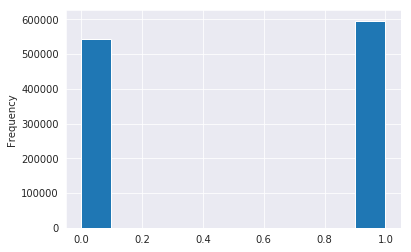

In [33]:
train_y.plot(kind='hist')

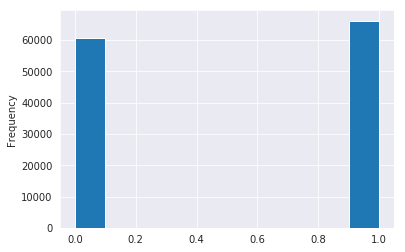

In [34]:
val_y.plot(kind='hist')

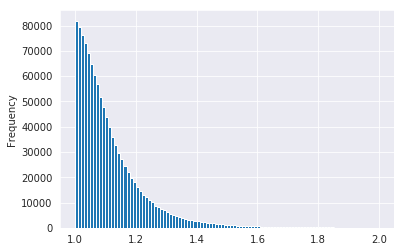

In [35]:
train_w.plot(kind='hist', bins=100)

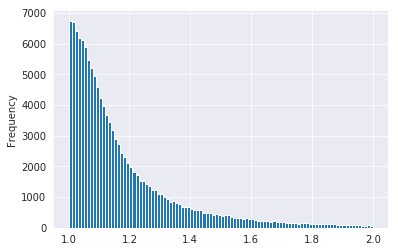

In [36]:
val_w.plot(kind='hist', bins=100)

In [41]:
classifier = CatBoostClassifier(
    iterations=5000, 
    learning_rate=0.003,
    depth=6,
#     l2_leaf_reg=1,
    loss_function='Logloss',
    eval_metric='Precision',
#     border_count=32,
#     leaf_estimation_iterations=10,
#     leaf_estimation_method='Newton',
    use_best_model=True,
    task_type='CPU'
)
classifier.fit(
    train_x,
    train_y,
    sample_weight=train_w,
    eval_set=Pool(val_x, val_y, weight=val_w),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

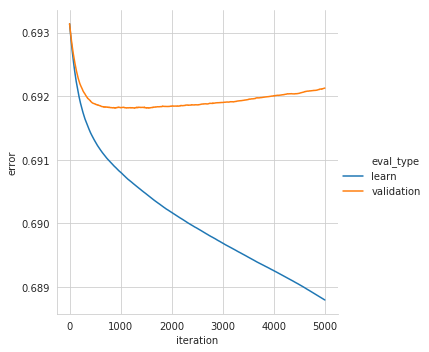

In [42]:
plot_learning_curve(classifier, 'Logloss')

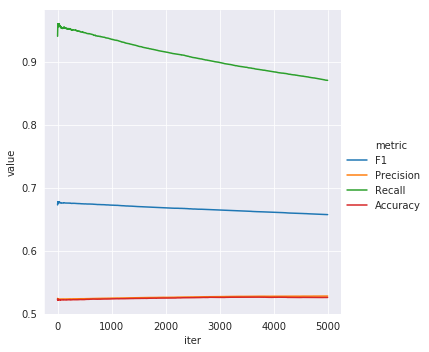

In [43]:
plot_eval_metrics(classifier, val_x, val_y, ['F1', 'Precision', 'Recall', 'Accuracy'])

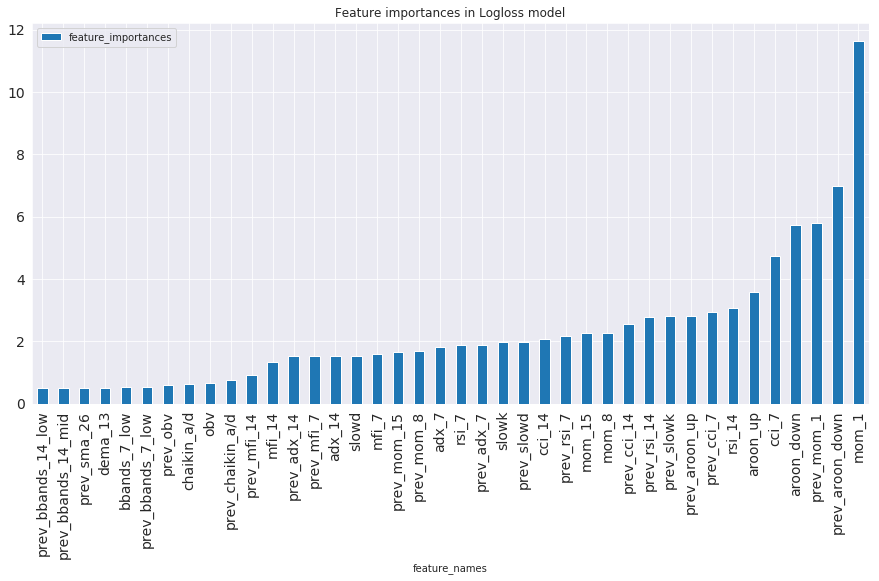

In [44]:
plot_feature_importance(classifier, 'Logloss', 40)

In [45]:
preds = classifier.predict_proba(test_x)
preds[:, 1].mean()

0.5216031857913734

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 6.000e+00, 5.000e+00,
        7.000e+00, 1.100e+01, 1.200e+01, 7.000e+00, 1.700e+01, 1.000e+01,
        2.300e+01, 1.700e+01, 2.000e+01, 2.500e+01, 3.000e+01, 3.500e+01,
        3.300e+01, 4.900e+01, 5.200e+01, 5.900e+01, 7.100e+01, 7.500e+01,
        9.200e+01, 9.800e+01, 1.190e+02, 1.510e+02, 1.370e+02, 1.610e+02,
        1.880e+02, 2.120e+02, 2.070e+02, 2.360e+02, 2.510e+02, 2.680e+02,
        2.830e+02, 3.500e+02, 3.630e+02, 3.970e+02, 4.060e+02, 4.230e+02,
        5.020e+02, 5.520e+02, 5.640e+02, 6.580e+02, 6.240e+02, 6.950e+02,
        7.930e+02, 8.630e+02, 9.300e+02, 9.300e+02, 9.520e+02, 1.138e+03,
        1.104e+03, 1.236e+03, 1.295e+0

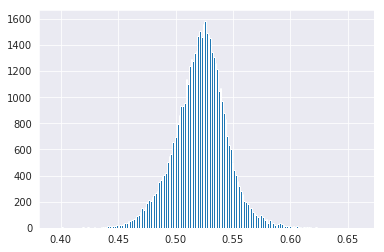

In [46]:
plt.hist(preds[:, 1], bins='auto')

In [47]:
df_test['pred'] = preds[:, 1]

In [48]:
df_test.head()

,sma_9,sma_13,sma_26,mom_1,mom_8,mom_15,rsi_7,rsi_14,slowd,slowk,...,prev_chaikin_a/d,prev_obv,prev_bbands_14_up,prev_bbands_14_mid,prev_bbands_14_low,prev_bbands_7_mid,prev_bbands_7_up,prev_bbands_7_low,target,pred
1040719,28.7899,28.0317,26.0852,0.2097,0.4095,4.1051,70.3198,64.8962,82.9769,85.7105,...,3.810929e+08,8.758905e+06,30.6180,27.5213,24.4245,28.7184,29.7793,27.6574,-0.007631,0.503646
2380753,32.5695,32.1804,32.5225,-1.1977,-1.0995,-0.4810,43.9051,46.8978,82.3203,75.4161,...,1.590358e+08,1.864051e+08,33.9951,32.0423,30.0895,32.6271,33.9093,31.3449,-0.004523,0.516488
812824,725.3728,720.9191,711.0349,16.4956,39.8437,31.1143,77.1774,66.9313,86.6800,88.3307,...,1.435739e+08,1.647544e+08,738.0645,718.1882,698.3119,724.3689,739.9943,708.7435,-0.002013,0.502226
2159689,59.8014,58.9272,58.8896,0.1579,0.4538,1.5095,60.6093,53.3221,86.4429,88.1400,...,4.873297e+08,1.003231e+09,61.6061,58.6392,55.6724,59.7626,60.2884,59.2367,-0.003960,0.533053
1534041,12.0678,11.7892,11.8604,0.2500,1.2700,0.6000,73.2231,59.1365,91.5689,95.4365,...,8.312267e+08,2.466407e+08,12.7431,11.6664,10.5898,11.9857,13.0585,10.9129,-0.118497,0.518745


In [65]:
good_pred = df_test[df_test['pred'] > 0.5]
bad_pred = df_test[df_test['pred'] < 0.5]

In [66]:
good_pred.shape, bad_pred.shape

((42476, 58), (7883, 58))

In [67]:
good_pred.target.mean(), bad_pred.target.mean()

(0.002099558757089563, 0.0008107283798377658)

In [68]:
good_pred[['target', 'pred']].sort_values('pred', ascending=False)[:30]

,target,pred
895784,-0.004541,0.659834
237032,-0.003466,0.640872
812912,0.020670,0.638416
37857,0.019310,0.632760
927099,0.017582,0.630840
797254,-0.028757,0.630829
1407479,0.004220,0.627179
595602,0.035517,0.626587
906258,-0.004024,0.623741
333984,0.006727,0.623698


In [69]:
good_pred[['target', 'pred']].sort_values('pred', ascending=False)[:500].target.mean()

0.010937544173352024

In [70]:
bad_pred[['target', 'pred']].sort_values('pred')[:30]

,target,pred
2234805,0.003475,0.394724
699960,0.003416,0.400792
2101308,-0.023925,0.400832
2234806,0.005329,0.401072
1031946,0.050620,0.402491
1207356,0.001074,0.405879
2229559,0.053589,0.408097
1508446,-0.000367,0.418914
1598705,-0.031252,0.419113
2154024,0.010222,0.419224


In [71]:
bad_pred[['target', 'pred']].sort_values('pred')[:500].target.mean()

-0.0009563426919118914

In [72]:
df_test[df_test['target'] > 0.01].shape, df_test[df_test['target'] < -0.01].shape

((15230, 58), (13212, 58))

In [73]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [74]:
pos_target_pred = df_test[df_test['target'] > 0.0].pred
neg_target_pred = df_test[df_test['target'] < -0.0].pred

pos_target_mean_pred = pos_target_pred.mean()
pos_target_std_pred = pos_target_pred.std()

neg_target_mean_pred = neg_target_pred.mean()
neg_target_std_pred = neg_target_pred.std()

In [75]:
print(pos_target_mean_pred)
print(_tconfint_generic(pos_target_mean_pred, pos_target_std_pred, 
                        len(pos_target_pred) - 1, 0.05, 'two-sided'))

0.52303914043704
(0.47813535290904413, 0.5679429279650359)


In [76]:
print(neg_target_mean_pred)
print(_tconfint_generic(neg_target_mean_pred, neg_target_std_pred, 
                        len(neg_target_pred) - 1, 0.05, 'two-sided'))

0.5200362875332581
(0.4758874624104739, 0.5641851126560424)


In [77]:
df_test[df_test['target'] > 0.01][['target', 'pred']].sort_values('target', ascending=False)

,target,pred
2363216,0.928779,0.493382
349834,0.428449,0.615877
442540,0.402720,0.517962
1965526,0.367078,0.517276
1295410,0.357147,0.519072
109959,0.352407,0.518648
1853246,0.332485,0.487910
885659,0.320883,0.525273
1270636,0.315102,0.520721
2229584,0.309226,0.512384


In [78]:
df_test[df_test['target'] < -0.01][['target', 'pred']].sort_values('target')

,target,pred
349837,-0.332634,0.531953
962139,-0.217679,0.438416
2258695,-0.209175,0.503283
1035519,-0.180677,0.541138
442541,-0.178808,0.493095
2317686,-0.165106,0.535197
1021423,-0.163600,0.511811
2363217,-0.156633,0.467088
94442,-0.153354,0.527852
1283553,-0.152731,0.517602


In [82]:
pos_target = df_test[df_test['target'] > 0]
pos_target.shape, sum(pos_target.pred > 0.5), sum(pos_target.pred < 0.5)

((26171, 58), 22433, 3738)

In [81]:
neg_target = df_test[df_test['target'] < 0]
neg_target.shape, sum(neg_target.pred > 0.5), sum(neg_target.pred < 0.5)

((23947, 58), 19836, 4111)